## Convolutional Neural Network
**problem**: Chapter 6 of the textbook.

In this exercise, you will construct a convolutional neural network (CNN) for image recognition using the MNIST dataset. This dataset is a subset of a larger set available from NIST. The MNIST dataset contains a total of 70,000 images of handwritten digits from 0 to 9 with corresponding labels, of which 55,000 examples are in the training set, 5,000 in the validation set, and 10,000 in the test set. The digits have been size-normalized and centered in a fixedsize image, so you don’t need to do any preprocessing to the images.
## Imports ##

In [10]:
%matplotlib inline
import tensorflow as tf
import keras
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## Load data

Tensorflow and Keras allow us to import and download the MNIST dataset directly from their API.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## Neural Network ##

In [47]:
class NeuralNetwork(object):

    def __init__(self, learning_rate=0.5, debug=False):
        """
        Train NeuralNetwork by fixed learning rate
        """
        self.neuron_layers = []
        self.batch_error = []
        self.learning_rate = learning_rate
        self.debug = debug

    def train(self, dataset, mini_batch):
        '''
        Convolution Layer
        '''
        conv1 = Convolution()
        conv2 = Convolution()
        '''
        Pooling Layer
        '''
        output_channels = 12
        ksize = 5
        stride = 1
        eta = np.zeros((BATCH_SIZE, int((28 - ksize + 1) / stride), int((28 - ksize + 1) / stride), output_channels))
        output_shape = eta.shape
        relu1 = Relu(output_shape)
        pool1 = MaxPooling(relu1.output_shape)
        
        if mini_batch:
            batch_num = 0
            self.batch_error = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            for inputs, outputs in dataset:
                if (batch_num%BATCH_SIZE == BATCH_SIZE-1) or (batch_num == len(dataset)):
                    self.feed_forward(inputs)
                    calculate_batch_error(outputs)
                    self.batch_error = self.batch_error/(batch_num%BATCH_SIZE+1)
                    feed_backword_batch(outputs)
                    self.update_weights(self.learning_rate)
                    self.batch_error = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                else:
                    self.feed_forward(inputs)
                    calculate_batch_error(outputs)
                batch_num += 1
        else:
            for inputs, outputs in dataset:
                '''
                Convolution & Pooling
                '''
                conv1.conv_forward(inputs, CONV_FILTER)
                '''
                Fully Connect
                '''
                self.feed_forward(inputs)
                self.feed_backword(outputs)
                self.update_weights(self.learning_rate)

    def feed_forward(self, inputs):
        s = inputs
        for (i, l) in enumerate(self.neuron_layers):
            s = l.feed_forward(s)
            if self.debug:
                print ("Layer %s:" % (i+1), " output:%s" % s)
        return s

    def feed_backword(self, outputs):
        layer_num = len(self.neuron_layers)
        l = layer_num
        previous_deltas = [] 
        while l != 0:
            current_layer = self.neuron_layers[l - 1]
            if len(previous_deltas) == 0:
                for i in range(len(current_layer.neurons)):
                    error = -(outputs[i] - current_layer.neurons[i].output)
                    current_layer.neurons[i].calculate_delta(error)
            else:
                previous_layer = self.neuron_layers[l]
                for i in range(len(current_layer.neurons)):
                    error = 0
                    for j in range(len(previous_deltas)):
                        error += previous_deltas[j] * previous_layer.neurons[j].weights[i]
                    current_layer.neurons[i].calculate_delta(error)
            previous_deltas = current_layer.get_deltas()
            if self.debug:
                print ("Layer %s:" % l, "deltas:%s" % previous_deltas)
            l -= 1
            
    def feed_backword_batch(self, outputs):
        layer_num = len(self.neuron_layers)
        l = layer_num
        previous_deltas = [] 
        # Batch size - fitst output
        current_layer = self.neuron_layers[l - 1]
        for i in range(len(current_layer.neurons)):
            error = self.batch_error
            current_layer.neurons[i].calculate_delta(error)
        previous_deltas = current_layer.get_deltas()
        if self.debug:
            print ("Layer %s:" % l, "deltas:%s" % previous_deltas)
        l -= 1
        # Batch size
        while l != 0:
            current_layer = self.neuron_layers[l - 1]
            if len(previous_deltas) == 0:
                for i in range(len(current_layer.neurons)):
                    error = -(outputs[i] - current_layer.neurons[i].output)
                    current_layer.neurons[i].calculate_delta(error)
            else:
                previous_layer = self.neuron_layers[l]
                for i in range(len(current_layer.neurons)):
                    error = 0
                    for j in range(len(previous_deltas)):
                        error += previous_deltas[j] * previous_layer.neurons[j].weights[i]
                    current_layer.neurons[i].calculate_delta(error)
            previous_deltas = current_layer.get_deltas()
            if self.debug:
                print ("Layer %s:" % l, "deltas:%s" % previous_deltas)
            l -= 1

    def update_weights(self, learning_rate):
        for l in self.neuron_layers:
            l.update_weights(learning_rate)

    def calculate_total_error(self, dataset):
        """
        Return mean squared error of dataset
        """
        total_error = 0
        for inputs, outputs in dataset:
            actual_outputs = self.feed_forward(inputs)
            for i in range(len(outputs)):
                total_error += (outputs[i] - actual_outputs[i]) ** 2
        return total_error

    def calculate_batch_error(self, outputs):
        layer_num = len(self.neuron_layers)
        l = layer_num
        current_layer = self.neuron_layers[l - 1]
        for i in range(len(current_layer.neurons)):
            self.batch_error[i] -= (outputs[i] - current_layer.neurons[i].output)

    def get_output(self, inputs):
        return self.feed_forward(inputs)

    def add_layer(self, neruon_layer):
        self.neuron_layers.append(neruon_layer)

    def dump(self):
        for (i, l) in enumerate(self.neuron_layers):
            print ("Dump layer: %s" % (i+1))
            l.dump()

In [48]:
class NeuronLayer(object):

    def __init__(self, input_num, neuron_num, init_weights=[], bias=1):
        self.neurons = []
        weight_index = 0
        for i in range(neuron_num):
            n = Neuron(input_num)
            for j in range(input_num):
                if weight_index < len(init_weights):
                    n.weights[j] = init_weights[weight_index]
                    weight_index += 1
            n.bias = bias
            self.neurons.append(n)

    def feed_forward(self, inputs):
        outputs = []
        for n in self.neurons:
            outputs.append(n.calculate_output(inputs))
        return outputs

    def get_deltas(self):
        return [n.delta for n in self.neurons]

    def update_weights(self, learning_rate):
        for n in self.neurons:
            n.update_weights(learning_rate)

    def dump(self):
        for (i, n) in enumerate(self.neurons):
            print ("\t-Dump neuron: %s" % (i+1))
            n.dump()

## Neuron ##
### Initialize the Weights of Neural Network ###
Using random function to randomly generate the weights.
### Calculate Output ###
$$z=\omega_{1}*x_{1}+\omega_{2}∗x_{2}+\omega_{3}∗bias$$

then using activation function(sigmoid function) to calculate the output

$$s=\frac{1}{1+e^{−z}}$$

then using activation function(relu function) to calculate the output

$$s=max(x, 0)$$
### Activation Function ###
$$s=\frac{1}{1+e^{−z}}$$
### Calculate Delta ###
The error influence:
$$\delta_{L}=(realOutput−expectOutput)∗g′(z)$$

$$g'(z)=o∗(1−o)$$
### Update Weights ###
$$\delta_{L}=\omega_{L+1}\delta_{L+1}∗g′(z)$$

new weights: $$\omega_{i}=\omega_{i}−\alpha∗\delta∗x_{i}$$

new bias: $$\omega_{bias}=\omega_{bias}−\alpha∗\delta$$


In [15]:
class Neuron(object):

    def __init__(self, weight_num):
        self.weights = []
        self.bias = 0
        self.output = 0
        self.delta = 0
        self.inputs = []
        for i in range(weight_num):
            self.weights.append(random.random())

    def calculate_output(self, inputs):
        self.inputs = inputs
        if len(inputs) != len(self.weights):
            raise Exception("Input number not fit weight number")
        self.output = 0
        for (i, w) in enumerate(self.weights):
            self.output += w * inputs[i]
        self.output = self.activation_function(self.output + self.bias)
        return self.output

    def activation_function(self, x):
        """Using sigmoid function"""
        #return 1 / (1 + math.exp(-x))
        """Using relu function"""
        return np.maximum(x, 0)

    def calculate_delta(self, error):
        """ Using g' of sigmoid """
        self.delta = error * self.output * (1 - self.output)

    def update_weights(self, learning_rate):
        for (i, w) in enumerate(self.weights):
            new_w = w - learning_rate * self.delta * self.inputs[i]
            self.weights[i] = new_w
        self.bias = self.bias - learning_rate * self.delta

    def dump(self):
        print ("\t\t-- weights:", self.weights)
        print ("\t\t-- bias:", self.bias)

## Forward Convolution ##

<img src="./forwardpass_convolution.PNG">
$$h_{11}=\omega_{11}*x_{11}+\omega_{12}∗x_{12}+\omega_{21}∗x_{21}+\omega_{22}∗x_{22}$$
$$h_{12}=\omega_{11}*x_{12}+\omega_{12}∗x_{13}+\omega_{21}∗x_{22}+\omega_{22}∗x_{23}$$
$$h_{21}=\omega_{11}*x_{21}+\omega_{12}∗x_{22}+\omega_{21}∗x_{31}+\omega_{22}∗x_{32}$$
$$h_{22}=\omega_{11}*x_{22}+\omega_{12}∗x_{23}+\omega_{21}∗x_{32}+\omega_{22}∗x_{33}$$

## Backward Convolution ##

<img src="./backwardpass_convolution.PNG">
$$\delta\omega_{11}=x_{11}\delta h_{11}+x_{12}\delta h_{12}+x_{21}\delta h_{21}+x_{22}\delta h_{22}$$
$$\delta\omega_{12}=x_{12}\delta h_{11}+x_{13}\delta h_{12}+x_{22}\delta h_{21}+x_{23}\delta h_{22}$$
$$\delta\omega_{21}=x_{21}\delta h_{11}+x_{22}\delta h_{12}+x_{31}\delta h_{21}+x_{32}\delta h_{22}$$
$$\delta\omega_{22}=x_{22}\delta h_{11}+x_{23}\delta h_{12}+x_{32}\delta h_{21}+x_{33}\delta h_{22}$$

In [36]:
class Convolution(object):
    
    def conv_forward(self, X, W):
        '''
        The forward computation for a convolution function

        Arguments:
        X -- output activations of the previous layer, numpy array of shape (n_H_prev, n_W_prev) assuming input channels = 1
        W -- Weights, numpy array of size (f, f) assuming number of filters = 1

        Returns:
        H -- conv output, numpy array of size (n_H, n_W)
        cache -- cache of values needed for conv_backward() function
        '''

        # Retrieving dimensions from X's shape
        (n_H_prev, n_W_prev) = X.shape

        # Retrieving dimensions from W's shape
        (f, f) = W.shape

        # Compute the output dimensions assuming no padding and stride = 1
        n_H = n_H_prev - f + 1
        n_W = n_W_prev - f + 1

        # Initialize the output H with zeros
        H = np.zeros((n_H, n_W))

        # Looping over vertical(h) and horizontal(w) axis of output volume
        for h in range(n_H):
            for w in range(n_W):
                x_slice = X[h:h+f, w:w+f]
                H[h,w] = np.sum(x_slice * W)

        # Saving information in 'cache' for backprop
        cache = (X, W)

        return H, cache
    
    def conv_backward(self, dH, cache):
        '''
        The backward computation for a convolution function

        Arguments:
        dH -- gradient of the cost with respect to output of the conv layer (H), numpy array of shape (n_H, n_W) assuming channels = 1
        cache -- cache of values needed for the conv_backward(), output of conv_forward()

        Returns:
        dX -- gradient of the cost with respect to input of the conv layer (X), numpy array of shape (n_H_prev, n_W_prev) assuming channels = 1
        dW -- gradient of the cost with respect to the weights of the conv layer (W), numpy array of shape (f,f) assuming single filter
        '''

        # Retrieving information from the "cache"
        (X, W) = cache

        # Retrieving dimensions from X's shape
        (n_H_prev, n_W_prev) = X.shape

        # Retrieving dimensions from W's shape
        (f, f) = W.shape

        # Retrieving dimensions from dH's shape
        (n_H, n_W) = dH.shape

        # Initializing dX, dW with the correct shapes
        dX = np.zeros(X.shape)
        dW = np.zeros(W.shape)

        # Looping over vertical(h) and horizontal(w) axis of the output
        for h in range(n_H):
            for w in range(n_W):
                dX[h:h+f, w:w+f] += W * dH(h,w)
                dW += X[h:h+f, w:w+f] * dH(h,w)

        return dX, dW

## RELU ##

In [24]:
class Relu(object):
    def __init__(self, shape):
        self.eta = np.zeros(shape)
        self.x = np.zeros(shape)
        self.output_shape = shape

    def forward(self, x):
        self.x = x
        return np.maximum(x, 0)

    def gradient(self, eta):
        self.eta = eta
        self.eta[self.x<0]=0
        return self.eta

## Pooling ##

In [25]:
class MaxPooling(object):
    def __init__(self, shape, ksize=2, stride=2):
        self.input_shape = shape
        self.ksize = ksize
        self.stride = stride
        self.output_channels = shape[-1]
        self.index = np.zeros(shape)
        self.output_shape = [shape[0], shape[1] / self.stride, shape[2] / self.stride, self.output_channels]

    def forward(self, x):
        out = np.zeros([x.shape[0], x.shape[1] / self.stride, x.shape[2] / self.stride, self.output_channels])

        for b in range(x.shape[0]):
            for c in range(self.output_channels):
                for i in range(0, x.shape[1], self.stride):
                    for j in range(0, x.shape[2], self.stride):
                        out[b, i / self.stride, j / self.stride, c] = np.max(
                            x[b, i:i + self.ksize, j:j + self.ksize, c])
                        index = np.argmax(x[b, i:i + self.ksize, j:j + self.ksize, c])
                        self.index[b, i+index/self.stride, j + index % self.stride, c] = 1
        return out

    def gradient(self, eta):
        return np.repeat(np.repeat(eta, self.stride, axis=1), self.stride, axis=2) * self.index
    
    def pooling_forward(self):
        

## Convolution and Pooling ##

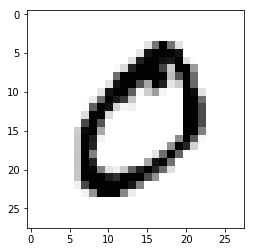

In [40]:
image_index = 1
plt.imshow(x_train[image_index], cmap='Greys')

In [79]:
CONV_FILTER = np.random.standard_normal((3, 3))
conv1 = Convolution()
conv2 = Convolution()
conv1.conv_forward(x_train[image_index], CONV_FILTER)

(array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+

In [80]:
output_channels = 12
ksize = 5
stride = 1
eta = np.zeros((BATCH_SIZE, int((28 - ksize + 1) / stride), int((28 - ksize + 1) / stride), output_channels))
output_shape = eta.shape

relu1 = Relu(output_shape)
pool1 = MaxPooling(relu1.output_shape)

## Train ##

In [49]:
nn = NeuralNetwork()
hidden_layer_1 = NeuronLayer(input_num=15, neuron_num=10, bias=1)
hidden_layer_2 = NeuronLayer(input_num=10, neuron_num=10, bias=1)
output_layer = NeuronLayer(input_num=10, neuron_num=1, bias=1)
nn.add_layer(hidden_layer_1)
nn.add_layer(hidden_layer_2)
nn.add_layer(output_layer)
# nn.dump()

In [63]:
tracking = []
BATCH_SIZE = 64
for i in range(1):
    nn.train(dataset, 0)
    tracking.append(nn.calculate_total_error(dataset))

NameError: name 'dataset' is not defined

In [71]:
img = x_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE].reshape([BATCH_SIZE, 28, 28, 1])

(28, 28, 1)
